In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Dataset imports:
from data.dataset import *

# Data augmenter imports:
from data.data_augmentation import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split

# Model imports:
from model import *

# Train and evaluation imports:
from train import train
from evaluate import evaluate

# Custom Transforms imports:
from custom_transforms import *

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math
import random

# Other imports:
from tqdm import tqdm

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print(f'Using: {torch.cuda.get_device_name(0)}')
print(f'Current device: {device}')

Using: NVIDIA GeForce RTX 3080
Current device: cuda


In [5]:
torch.backends.cudnn.benchmark = True

# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [6]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [7]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.

# Creating the sharpness transform:
sharpen = Sharpen(sharpness_factor=2)

image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std),
                            sharpen])

# Defining the dataset:

In [8]:
# Creating the dataset instance:
test_dataset = SkinCancerDataset(transform=image_preprocessing)

### The dataset class distribution:

In [9]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

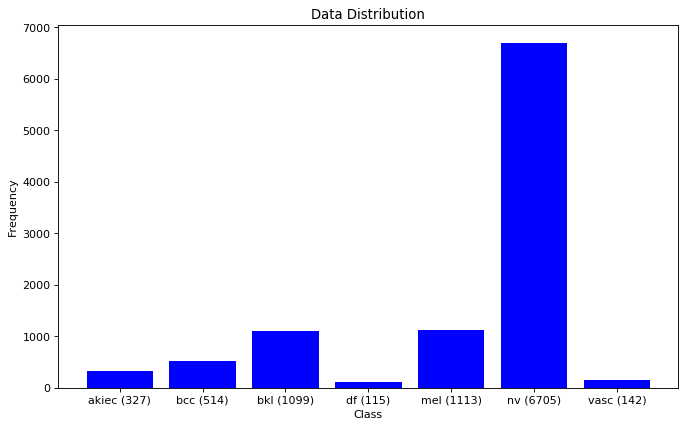

In [10]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [11]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [12]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32, num_workers=8)

### Creating the model:

In [13]:
model_overfit = SkinCancerModel()

### The hyperparameters, the loss function and the optimizer:

In [14]:
learning_rate = 1e-3
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_overfit.parameters(), lr=learning_rate, momentum=momentum)

In [14]:
epochs = 60

### Overfitting the model:

In [15]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)


  0%|          | 0/60 [00:00<?, ?it/s]

Evaluating epoch...



  2%|▏         | 1/60 [00:26<25:40, 26.11s/it]

Epoch: 0 | Train_acc: 52.00% | Val_acc: 52.00% | Loss: 7.84 | Runtime: 26.11 seconds
Evaluating epoch...



  3%|▎         | 2/60 [00:48<23:13, 24.03s/it]

Epoch: 1 | Train_acc: 52.00% | Val_acc: 52.00% | Loss: 3.62 | Runtime: 22.57 seconds
Evaluating epoch...



  5%|▌         | 3/60 [01:11<22:12, 23.37s/it]

Epoch: 2 | Train_acc: 52.00% | Val_acc: 52.00% | Loss: 3.40 | Runtime: 22.60 seconds
Evaluating epoch...



  7%|▋         | 4/60 [01:33<21:28, 23.01s/it]

Epoch: 3 | Train_acc: 57.00% | Val_acc: 57.00% | Loss: 3.18 | Runtime: 22.45 seconds
Evaluating epoch...



  8%|▊         | 5/60 [01:55<20:49, 22.71s/it]

Epoch: 4 | Train_acc: 52.00% | Val_acc: 52.00% | Loss: 3.11 | Runtime: 22.19 seconds
Evaluating epoch...



 10%|█         | 6/60 [02:18<20:19, 22.58s/it]

Epoch: 5 | Train_acc: 57.00% | Val_acc: 57.00% | Loss: 3.01 | Runtime: 22.32 seconds
Evaluating epoch...



 12%|█▏        | 7/60 [02:40<19:57, 22.60s/it]

Epoch: 6 | Train_acc: 60.00% | Val_acc: 60.00% | Loss: 3.22 | Runtime: 22.64 seconds
Evaluating epoch...



 13%|█▎        | 8/60 [03:03<19:28, 22.47s/it]

Epoch: 7 | Train_acc: 52.00% | Val_acc: 52.00% | Loss: 2.84 | Runtime: 22.18 seconds
Evaluating epoch...



 15%|█▌        | 9/60 [03:25<19:05, 22.47s/it]

Epoch: 8 | Train_acc: 57.00% | Val_acc: 57.00% | Loss: 2.94 | Runtime: 22.46 seconds
Evaluating epoch...



 17%|█▋        | 10/60 [03:47<18:42, 22.45s/it]

Epoch: 9 | Train_acc: 58.00% | Val_acc: 58.00% | Loss: 2.75 | Runtime: 22.40 seconds
Evaluating epoch...



 18%|█▊        | 11/60 [04:10<18:15, 22.36s/it]

Epoch: 10 | Train_acc: 58.00% | Val_acc: 58.00% | Loss: 2.75 | Runtime: 22.16 seconds
Evaluating epoch...



 20%|██        | 12/60 [04:32<17:50, 22.29s/it]

Epoch: 11 | Train_acc: 68.00% | Val_acc: 68.00% | Loss: 2.49 | Runtime: 22.14 seconds
Evaluating epoch...



 22%|██▏       | 13/60 [04:54<17:26, 22.26s/it]

Epoch: 12 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 2.53 | Runtime: 22.18 seconds
Evaluating epoch...



 23%|██▎       | 14/60 [05:16<17:05, 22.30s/it]

Epoch: 13 | Train_acc: 71.00% | Val_acc: 71.00% | Loss: 2.59 | Runtime: 22.38 seconds
Evaluating epoch...



 25%|██▌       | 15/60 [05:39<16:44, 22.33s/it]

Epoch: 14 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 2.52 | Runtime: 22.41 seconds
Evaluating epoch...



 27%|██▋       | 16/60 [06:01<16:20, 22.29s/it]

Epoch: 15 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 2.44 | Runtime: 22.20 seconds
Evaluating epoch...



 28%|██▊       | 17/60 [06:23<15:58, 22.29s/it]

Epoch: 16 | Train_acc: 74.00% | Val_acc: 74.00% | Loss: 2.46 | Runtime: 22.28 seconds
Evaluating epoch...



 30%|███       | 18/60 [06:46<15:38, 22.36s/it]

Epoch: 17 | Train_acc: 75.00% | Val_acc: 75.00% | Loss: 2.57 | Runtime: 22.51 seconds
Evaluating epoch...



 32%|███▏      | 19/60 [07:08<15:14, 22.30s/it]

Epoch: 18 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 2.24 | Runtime: 22.16 seconds
Evaluating epoch...



 33%|███▎      | 20/60 [07:30<14:53, 22.34s/it]

Epoch: 19 | Train_acc: 74.00% | Val_acc: 74.00% | Loss: 2.42 | Runtime: 22.44 seconds
Evaluating epoch...



 35%|███▌      | 21/60 [07:53<14:31, 22.35s/it]

Epoch: 20 | Train_acc: 60.00% | Val_acc: 60.00% | Loss: 2.10 | Runtime: 22.38 seconds
Evaluating epoch...



 37%|███▋      | 22/60 [08:15<14:06, 22.29s/it]

Epoch: 21 | Train_acc: 63.00% | Val_acc: 63.00% | Loss: 2.14 | Runtime: 22.14 seconds
Evaluating epoch...



 38%|███▊      | 23/60 [08:37<13:44, 22.27s/it]

Epoch: 22 | Train_acc: 77.00% | Val_acc: 77.00% | Loss: 2.33 | Runtime: 22.23 seconds
Evaluating epoch...



 40%|████      | 24/60 [08:59<13:20, 22.24s/it]

Epoch: 23 | Train_acc: 77.00% | Val_acc: 77.00% | Loss: 2.24 | Runtime: 22.17 seconds
Evaluating epoch...



 42%|████▏     | 25/60 [09:21<12:58, 22.25s/it]

Epoch: 24 | Train_acc: 80.00% | Val_acc: 80.00% | Loss: 2.09 | Runtime: 22.27 seconds
Evaluating epoch...



 43%|████▎     | 26/60 [09:44<12:35, 22.21s/it]

Epoch: 25 | Train_acc: 74.00% | Val_acc: 74.00% | Loss: 2.10 | Runtime: 22.13 seconds
Evaluating epoch...



 45%|████▌     | 27/60 [10:06<12:14, 22.26s/it]

Epoch: 26 | Train_acc: 81.00% | Val_acc: 81.00% | Loss: 2.22 | Runtime: 22.36 seconds
Evaluating epoch...



 47%|████▋     | 28/60 [10:28<11:49, 22.19s/it]

Epoch: 27 | Train_acc: 77.00% | Val_acc: 77.00% | Loss: 2.27 | Runtime: 22.02 seconds
Evaluating epoch...



 48%|████▊     | 29/60 [10:50<11:28, 22.21s/it]

Epoch: 28 | Train_acc: 79.00% | Val_acc: 79.00% | Loss: 2.09 | Runtime: 22.27 seconds
Evaluating epoch...



 50%|█████     | 30/60 [11:12<11:05, 22.19s/it]

Epoch: 29 | Train_acc: 77.00% | Val_acc: 77.00% | Loss: 2.10 | Runtime: 22.13 seconds
Evaluating epoch...



 52%|█████▏    | 31/60 [11:35<10:44, 22.24s/it]

Epoch: 30 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 2.06 | Runtime: 22.36 seconds
Evaluating epoch...



 53%|█████▎    | 32/60 [11:57<10:24, 22.30s/it]

Epoch: 31 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 1.71 | Runtime: 22.44 seconds
Evaluating epoch...



 55%|█████▌    | 33/60 [12:19<10:00, 22.26s/it]

Epoch: 32 | Train_acc: 84.00% | Val_acc: 84.00% | Loss: 2.39 | Runtime: 22.17 seconds
Evaluating epoch...



 57%|█████▋    | 34/60 [12:42<09:39, 22.30s/it]

Epoch: 33 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 1.99 | Runtime: 22.41 seconds
Evaluating epoch...



 58%|█████▊    | 35/60 [13:04<09:16, 22.26s/it]

Epoch: 34 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 2.22 | Runtime: 22.16 seconds
Evaluating epoch...



 60%|██████    | 36/60 [13:26<08:54, 22.26s/it]

Epoch: 35 | Train_acc: 77.00% | Val_acc: 77.00% | Loss: 1.61 | Runtime: 22.25 seconds
Evaluating epoch...



 62%|██████▏   | 37/60 [13:48<08:30, 22.22s/it]

Epoch: 36 | Train_acc: 82.00% | Val_acc: 82.00% | Loss: 1.97 | Runtime: 22.11 seconds
Evaluating epoch...



 63%|██████▎   | 38/60 [14:11<08:10, 22.30s/it]

Epoch: 37 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 1.72 | Runtime: 22.51 seconds
Evaluating epoch...



 65%|██████▌   | 39/60 [14:33<07:48, 22.32s/it]

Epoch: 38 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.69 | Runtime: 22.34 seconds
Evaluating epoch...



 67%|██████▋   | 40/60 [14:55<07:25, 22.27s/it]

Epoch: 39 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 1.45 | Runtime: 22.15 seconds
Evaluating epoch...



 68%|██████▊   | 41/60 [15:18<07:03, 22.30s/it]

Epoch: 40 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.87 | Runtime: 22.37 seconds
Evaluating epoch...



 70%|███████   | 42/60 [15:40<06:40, 22.27s/it]

Epoch: 41 | Train_acc: 69.00% | Val_acc: 69.00% | Loss: 1.63 | Runtime: 22.21 seconds
Evaluating epoch...



 72%|███████▏  | 43/60 [16:02<06:18, 22.26s/it]

Epoch: 42 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.82 | Runtime: 22.23 seconds
Evaluating epoch...



 73%|███████▎  | 44/60 [16:24<05:55, 22.23s/it]

Epoch: 43 | Train_acc: 90.00% | Val_acc: 90.00% | Loss: 1.46 | Runtime: 22.15 seconds
Evaluating epoch...



 75%|███████▌  | 45/60 [16:46<05:33, 22.22s/it]

Epoch: 44 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.41 | Runtime: 22.20 seconds
Evaluating epoch...



 77%|███████▋  | 46/60 [17:09<05:11, 22.28s/it]

Epoch: 45 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.61 | Runtime: 22.41 seconds
Evaluating epoch...



 78%|███████▊  | 47/60 [17:31<04:50, 22.31s/it]

Epoch: 46 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.45 | Runtime: 22.39 seconds
Evaluating epoch...



 80%|████████  | 48/60 [17:53<04:27, 22.27s/it]

Epoch: 47 | Train_acc: 90.00% | Val_acc: 90.00% | Loss: 1.58 | Runtime: 22.19 seconds
Evaluating epoch...



 82%|████████▏ | 49/60 [18:16<04:04, 22.21s/it]

Epoch: 48 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.42 | Runtime: 22.07 seconds
Evaluating epoch...



 83%|████████▎ | 50/60 [18:38<03:41, 22.19s/it]

Epoch: 49 | Train_acc: 90.00% | Val_acc: 90.00% | Loss: 1.48 | Runtime: 22.15 seconds
Evaluating epoch...



 85%|████████▌ | 51/60 [19:00<03:20, 22.23s/it]

Epoch: 50 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.33 | Runtime: 22.32 seconds
Evaluating epoch...



 87%|████████▋ | 52/60 [19:22<02:57, 22.23s/it]

Epoch: 51 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.29 | Runtime: 22.22 seconds
Evaluating epoch...



 88%|████████▊ | 53/60 [19:44<02:35, 22.17s/it]

Epoch: 52 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.22 | Runtime: 22.03 seconds
Evaluating epoch...



 90%|█████████ | 54/60 [20:06<02:12, 22.16s/it]

Epoch: 53 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 1.55 | Runtime: 22.13 seconds
Evaluating epoch...



 92%|█████████▏| 55/60 [20:29<01:50, 22.18s/it]

Epoch: 54 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.13 | Runtime: 22.23 seconds
Evaluating epoch...



 93%|█████████▎| 56/60 [20:51<01:28, 22.18s/it]

Epoch: 55 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.22 | Runtime: 22.17 seconds
Evaluating epoch...



 95%|█████████▌| 57/60 [21:13<01:06, 22.31s/it]

Epoch: 56 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 1.14 | Runtime: 22.61 seconds
Evaluating epoch...



 97%|█████████▋| 58/60 [21:36<00:44, 22.26s/it]

Epoch: 57 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.38 | Runtime: 22.16 seconds
Evaluating epoch...



 98%|█████████▊| 59/60 [21:57<00:22, 22.15s/it]

Epoch: 58 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.17 | Runtime: 21.89 seconds
Evaluating epoch...


100%|██████████| 60/60 [22:20<00:00, 22.33s/it]

Epoch: 59 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 1.10 | Runtime: 22.14 seconds


In [ ]:
figure(figsize=(5, 3), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, color='b')

plt.show()

figure(figsize=(5, 3), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, color='r')
plt.show()

# Setting up the actual model:

### Defining the Dataset object:

In [8]:
dataset = SkinCancerDataset()

### Splitting the dataset into train, validation, and test sets:

In [9]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.8
validation_proportion = 0.1
test_proportion = 0.1

# Defining the sizes of the splits:

# 1) The train set size:
train_size = math.ceil(train_proportion * len(dataset))

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(dataset))

# 3) The test set size:
test_size = math.floor(test_proportion * len(dataset))

# Defining the indecies of the train, validation and test sets:
all_indecies = np.random.choice(list(range(len(dataset))), (10, len(dataset) // 10), replace=False)

train_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(train_proportion * 10), replace=False)
val_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(validation_proportion * 10), replace=False)
test_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(test_proportion * 10), replace=False)

train_set_ind = np.append([], all_indecies[train_set_ind]).astype(np.int)
val_set_ind = np.append([], all_indecies[val_set_ind]).astype(np.int)
test_set_ind = np.append([], all_indecies[test_set_ind]).astype(np.int)

# # Defining the train, validation, and test sets:
class_threshold = 3000
train_set = SkinCancerDataset(indecies=train_set_ind, class_threshold=class_threshold)
validation_set = SkinCancerDataset(transform=image_preprocessing, indecies=val_set_ind)
test_set = SkinCancerDataset(transform=image_preprocessing, indecies=test_set_ind)

### Plotting the train data distribution before augmentation

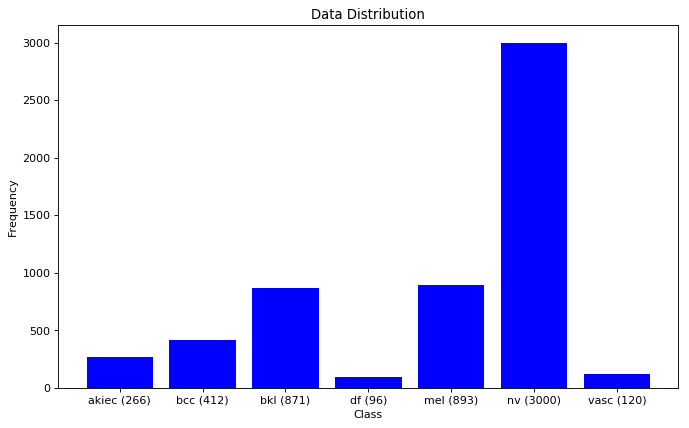

In [10]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')


data_dist = train_set.get_data_distribution()
y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Visualizing the preprocessed and the original data:

In [11]:
train_original = SkinCancerDataset(indecies=train_set_ind)
train_preprocessed = SkinCancerDataset(transform=image_preprocessing, indecies=train_set_ind)

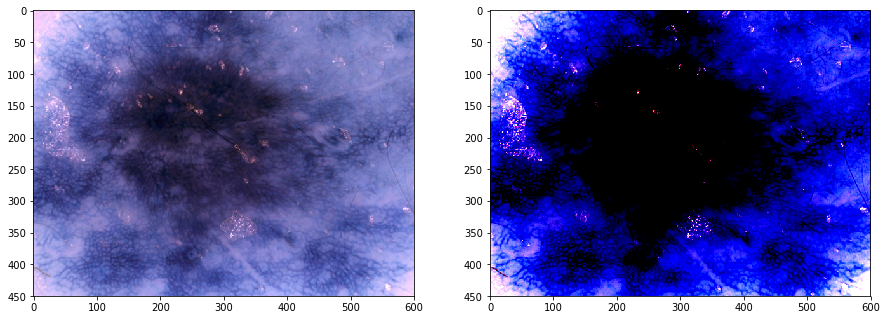

In [12]:
fig, axarr = plt.subplots(1,2)

fig.set_figheight(15)
fig.set_figwidth(15)

index = random.randint(0, len(train_original))

# Retrieving the images:
original_image = train_original[index][0]
preprocessed_image = train_preprocessed[index][0]

# Converting the images to numpy arrays so they can be plotted by matplotlib:
original_image = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
preprocessed_image = np.transpose(preprocessed_image.cpu().detach().numpy(), (1, 2, 0))

axarr[0].imshow(original_image)
axarr[1].imshow(preprocessed_image)

# Augmenting the training data:

In [13]:
augmentation_amount = np.array([class_threshold - i for i in data_dist.values()])
print(f'Number of data points to be augmented: {sum(augmentation_amount)}')
augmentation_amount

Number of data points to be augmented: 15342


array([2734, 2588, 2129, 2904, 2107,    0, 2880], dtype=int64)

In [14]:
train_set = SkinCancerDataset(transform=image_preprocessing, indecies=train_set_ind, augment=True, class_threshold=class_threshold)

In [15]:
data_dist = train_set.get_data_distribution()
data_dist

{'akiec': 3000,
 'bcc': 2989,
 'bkl': 2992,
 'df': 2993,
 'mel': 3000,
 'nv': 3000,
 'vasc': 3000}

In [16]:
len(train_set)

20974

# Plotting the data distribution after the augmentation:

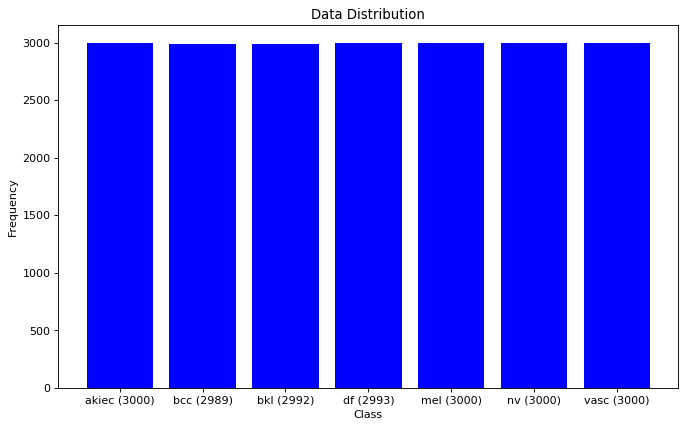

In [17]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Visualizing the augmented data:

bkl


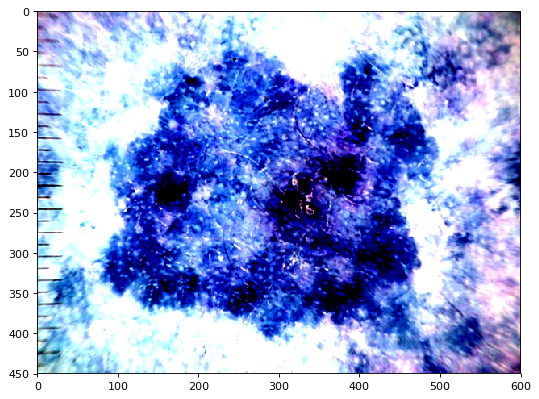

In [18]:
figure(figsize=(10, 6), dpi=80)

index = random.randint(0, len(train_set))
# index = random.randint(-sum(augmentation_amount), -1)

# Retrieving the images:
image = train_set[index][0]

# Converting the images to numpy arrays so they can be plotted by matplotlib:
image = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))

unmap = dict(zip(train_set.mapping.values(), train_set.mapping.keys()))

print(unmap[train_set[index][1]])
plt.imshow(image)

### Creating the DataLoader objects:

In [23]:
train_batch_size, validation_batch_size, test_batch_size = 32, 16, 16

# Setting the num_workers to the number of cores on this machine.
num_workers = 8

train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, batch_size=test_batch_size, num_workers=num_workers, pin_memory=True)

### Creating the model:

In [24]:
dropout_prob = 0.5

In [25]:
model = SkinCancerModel(dropout_prob=dropout_prob)

### Defining the optimizer, criterion, and hyperparameters:

In [26]:
learning_rate = 5e-3
weight_decay = 5e-7

# Defining the optimizer:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Defining the learning rate schedular:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)
 
# Defining the weighted loss function:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device=device)

### Defining the number of epochs:

In [27]:
epochs = 25

# Training the model

In [28]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            scheduler=scheduler,
                                                                            epochs=epochs,
                                                                            verbose=True)


  0%|          | 0/25 [00:00<?, ?it/s]

Evaluating epoch...



  4%|▍         | 1/25 [05:32<2:13:08, 332.87s/it]

Learning rate: 0.005
Epoch: 0 | Train_acc: 35.30% | Val_acc: 20.28% | Loss: 1506.48 | Runtime: 332.87 seconds
Evaluating epoch...



  8%|▊         | 2/25 [10:56<2:05:28, 327.33s/it]

Learning rate: 0.005
Epoch: 1 | Train_acc: 53.46% | Val_acc: 54.75% | Loss: 929.39 | Runtime: 323.45 seconds
Evaluating epoch...



 12%|█▏        | 3/25 [16:20<1:59:34, 326.10s/it]

Learning rate: 0.005
Epoch: 2 | Train_acc: 62.72% | Val_acc: 57.64% | Loss: 807.51 | Runtime: 324.64 seconds
Evaluating epoch...



 16%|█▌        | 4/25 [21:42<1:53:33, 324.44s/it]

Learning rate: 0.005
Epoch: 3 | Train_acc: 70.40% | Val_acc: 67.73% | Loss: 670.60 | Runtime: 321.89 seconds
Evaluating epoch...



 20%|██        | 5/25 [27:03<1:47:41, 323.07s/it]

Learning rate: 0.005
Epoch: 4 | Train_acc: 75.77% | Val_acc: 67.63% | Loss: 563.81 | Runtime: 320.64 seconds
Evaluating epoch...



 24%|██▍       | 6/25 [32:24<1:42:02, 322.23s/it]

Learning rate: 0.005
Epoch: 5 | Train_acc: 80.41% | Val_acc: 66.83% | Loss: 475.00 | Runtime: 320.59 seconds
Evaluating epoch...



 28%|██▊       | 7/25 [37:44<1:36:31, 321.72s/it]

Learning rate: 0.005
Epoch: 6 | Train_acc: 83.74% | Val_acc: 74.23% | Loss: 413.89 | Runtime: 320.69 seconds
Evaluating epoch...



 32%|███▏      | 8/25 [43:21<1:32:30, 326.50s/it]

Learning rate: 0.005
Epoch: 7 | Train_acc: 84.65% | Val_acc: 67.83% | Loss: 362.74 | Runtime: 336.72 seconds
Evaluating epoch...



 36%|███▌      | 9/25 [49:03<1:28:20, 331.31s/it]

Learning rate: 0.005
Epoch: 8 | Train_acc: 86.64% | Val_acc: 71.33% | Loss: 314.79 | Runtime: 341.88 seconds
Evaluating epoch...



 40%|████      | 10/25 [54:47<1:23:47, 335.16s/it]

Learning rate: 0.005
Epoch: 9 | Train_acc: 89.43% | Val_acc: 80.22% | Loss: 284.82 | Runtime: 343.79 seconds
Evaluating epoch...



 44%|████▍     | 11/25 [1:00:11<1:17:26, 331.91s/it]

Learning rate: 0.005
Epoch: 10 | Train_acc: 89.80% | Val_acc: 78.82% | Loss: 246.92 | Runtime: 324.52 seconds
Evaluating epoch...



 48%|████▊     | 12/25 [1:05:35<1:11:24, 329.55s/it]

Learning rate: 0.005
Epoch: 11 | Train_acc: 89.84% | Val_acc: 80.82% | Loss: 219.96 | Runtime: 324.16 seconds
Evaluating epoch...



 52%|█████▏    | 13/25 [1:11:23<1:07:01, 335.10s/it]

Learning rate: 0.005
Epoch: 12 | Train_acc: 91.82% | Val_acc: 75.42% | Loss: 207.26 | Runtime: 347.86 seconds
Evaluating epoch...



 56%|█████▌    | 14/25 [1:17:11<1:02:08, 338.92s/it]

Learning rate: 0.005
Epoch: 13 | Train_acc: 90.30% | Val_acc: 76.02% | Loss: 184.20 | Runtime: 347.75 seconds
Evaluating epoch...



 60%|██████    | 15/25 [1:22:57<56:51, 341.18s/it]  

Learning rate: 0.005
Epoch: 14 | Train_acc: 92.40% | Val_acc: 82.42% | Loss: 166.99 | Runtime: 346.40 seconds
Evaluating epoch...



 64%|██████▍   | 16/25 [1:28:41<51:18, 342.03s/it]

Learning rate: 0.005
Epoch: 15 | Train_acc: 94.11% | Val_acc: 84.12% | Loss: 153.16 | Runtime: 344.01 seconds
Evaluating epoch...



 68%|██████▊   | 17/25 [1:34:32<45:57, 344.66s/it]

Learning rate: 0.005
Epoch: 16 | Train_acc: 94.46% | Val_acc: 85.61% | Loss: 143.28 | Runtime: 350.77 seconds
Evaluating epoch...



 72%|███████▏  | 18/25 [1:40:20<40:18, 345.54s/it]

Learning rate: 0.0005
Epoch: 17 | Train_acc: 97.99% | Val_acc: 89.01% | Loss: 64.33 | Runtime: 347.58 seconds
Evaluating epoch...



 76%|███████▌  | 19/25 [1:46:07<34:35, 345.96s/it]

Learning rate: 0.0005
Epoch: 18 | Train_acc: 98.32% | Val_acc: 88.81% | Loss: 46.61 | Runtime: 346.96 seconds
Evaluating epoch...



 80%|████████  | 20/25 [1:51:53<28:51, 346.21s/it]

Learning rate: 0.0005
Epoch: 19 | Train_acc: 98.68% | Val_acc: 90.01% | Loss: 39.63 | Runtime: 346.78 seconds
Evaluating epoch...



 84%|████████▍ | 21/25 [1:57:34<22:57, 344.38s/it]

Learning rate: 0.0005
Epoch: 20 | Train_acc: 98.91% | Val_acc: 90.91% | Loss: 34.23 | Runtime: 340.10 seconds
Evaluating epoch...



 88%|████████▊ | 22/25 [2:03:20<17:14, 344.86s/it]

Learning rate: 0.0005
Epoch: 21 | Train_acc: 99.19% | Val_acc: 91.11% | Loss: 30.14 | Runtime: 345.99 seconds
Evaluating epoch...



 92%|█████████▏| 23/25 [2:09:09<11:32, 346.22s/it]

Learning rate: 0.0005
Epoch: 22 | Train_acc: 99.21% | Val_acc: 91.41% | Loss: 26.18 | Runtime: 349.39 seconds
Evaluating epoch...



 96%|█████████▌| 24/25 [2:14:58<05:47, 347.06s/it]

Learning rate: 0.0005
Epoch: 23 | Train_acc: 99.45% | Val_acc: 91.61% | Loss: 22.85 | Runtime: 349.00 seconds
Evaluating epoch...


100%|██████████| 25/25 [2:20:44<00:00, 337.78s/it]

Learning rate: 0.0005
Epoch: 24 | Train_acc: 99.37% | Val_acc: 91.51% | Loss: 19.90 | Runtime: 346.14 seconds


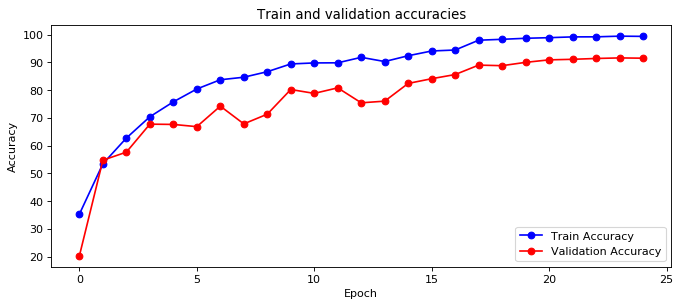

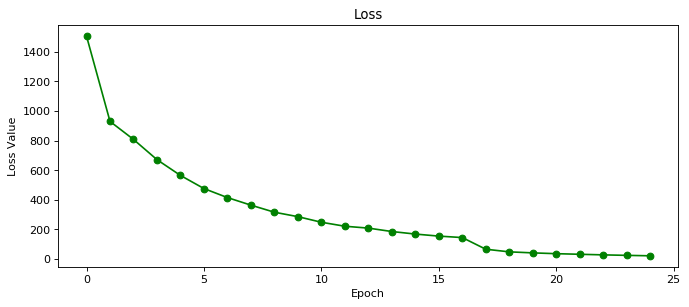

In [29]:
figure(figsize=(10, 4), dpi=80)
plt.title('Train and validation accuracies')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.plot(accuracies_validation, 'ro-')

plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()


figure(figsize=(10, 4), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, 'go-')
plt.show()

In [ ]:
for param in model.parameters():
    print(param.data)

# Evaluating the model with the test set:

In [30]:
test_accuracy = evaluate(model=model, data_loader=test_loader, device=device)

In [31]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 90.21%


In [32]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 90.21%


# Saving the model:

### Creating the path in which the model will be saved:

In [36]:
path = os.getcwd()
model_name = f'model_29_10'

In [37]:
MODEL_PATH = os.path.join(path, model_name)

### Saving the model:

In [38]:
torch.save(model.state_dict(), MODEL_PATH)

# Loading the model:

In [39]:
model = SkinCancerModel()
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [40]:
test_accuracy = evaluate(model=model, data_loader=test_loader, device=device)

In [41]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 90.21%


# Class Accuracies

In [33]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(test_loader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

63it [00:07,  7.96it/s]


In [34]:
classes = np.unique(test_set.labels)

class_accuracies = confusion_matrix.diag()/confusion_matrix.sum(1)
class_acc_dict = dict(zip(classes, class_accuracies.tolist()))
class_acc_dict

{'akiec': 1.0,
 'bcc': 1.0,
 'bkl': 0.9836065769195557,
 'df': 1.0,
 'mel': 0.9639639854431152,
 'nv': 0.8597561120986938,
 'vasc': 1.0}

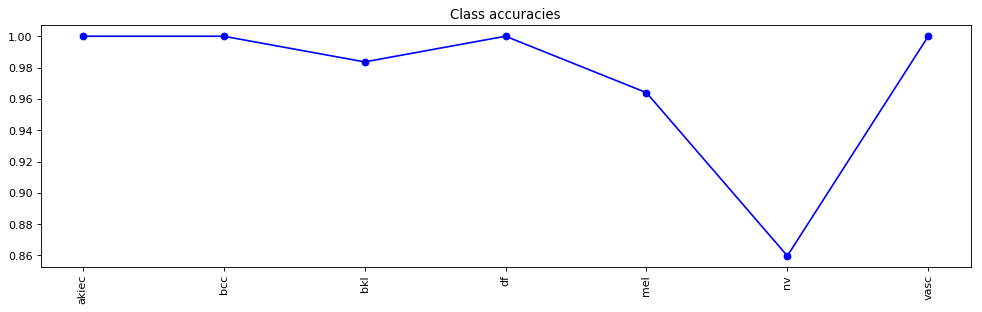

In [35]:
figure(figsize=(15, 4), dpi=80)
plt.title('Class accuracies')
y = class_accuracies.tolist()
x = classes
plt.plot(x, y, 'bo-')
plt.xticks(x, x, rotation=90)
plt.show()